**Load Data & Initial Overview**


In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib


# Load dataset and recognize -1, 'null', 'None' as missing values
df = pd.read_csv('transaction_dataset.csv', na_values=[-1, 'null', 'None'], index_col=0)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841 non-

**Standardize Column Names**

In [2]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")
df.rename(columns={
    "total_transactions_(including_tnx_to_create_contract": 
    "total_transactions_(including_tnx_to_create_contract)"
}, inplace=True)


In [3]:
df.head(10)

,index,address,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,...,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name,erc20_most_sent_token_type,erc20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
5,6,0x000895ad78f4403ecd9468900e68d6ee506136fd,0,9900.12,375.48,20926.68,2,3,0,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
6,7,0x000d63fc5df52b0204374c2f5a3249779805d5d1,0,69.46,629.44,8660.35,25,11,0,9,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
7,8,0x000e001ab444fa8d6dc4a402f8d7cfc88fe8c64d,0,1497.39,176.84,319828.05,213,5,0,3,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,7.0,NaN,XENON
8,9,0x0012cb699c836049a4bbeaac2d8c4d47c688e0e4,0,0.00,0.00,496.62,1,1,0,1,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
9,10,0x0012f247c9f980eea0a9ad06893bfd95c3145794,0,2570.59,3336.01,30572.70,8,3,0,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,NaN,AICRYPTO


**Drop Non-Useful Columns**

In [4]:
df.drop(columns=["index", "address"], inplace=True)


**Remove Duplicates**

In [5]:
df.duplicated().sum()

np.int64(546)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

np.int64(0)

**Standardize Categories**

In [8]:
df["erc20_most_sent_token_type"].value_counts().head(20)

erc20_most_sent_token_type
0                                4383
                                  948
EOS                               138
OmiseGO                           136
Golem                             129
blockwell.ai KYC Casper Token     128
StatusNetwork                      61
BAT                                38
Qtum                               34
Bancor                             32
Tronix                             26
Reputation                         26
TenXPay                            25
Crypto.com                         20
ICONOMI                            19
Aragon                             19
Civic                              18
Aeternity                          18
ZRX                                15
Veritaseum                         14
Name: count, dtype: int64

In [9]:
df["erc20_most_sent_token_type"] = df["erc20_most_sent_token_type"].apply(
    lambda x: "No_Token" if (x == "0" or str(x).strip() == "")
    else ("Other" if not pd.isna(x) else np.nan)
)

In [10]:
df["erc20_most_sent_token_type"].value_counts().head()

erc20_most_sent_token_type
No_Token    5331
Other       1550
Name: count, dtype: int64

In [11]:
df["erc20_most_rec_token_type"].value_counts().head(20)

erc20_most_rec_token_type
0                                   4383
OmiseGO                              870
Blockwell say NOTSAFU                539
DATAcoin                             358
Livepeer Token                       205
EOS                                  161
XENON                                145
Golem                                126
GSENetwork                            80
Tronix                                76
blockwell.ai KYC Casper Token         65
Promodl                               52
VIU                                   50
INS Promo                             44
Bulleon Promo Token                   44
KickCoin                              43
StatusNetwork                         42
Free BOB Tokens - BobsRepair.com      38
BAT                                   36
ERC20                                 35
Name: count, dtype: int64

In [12]:
df["erc20_most_rec_token_type"] = df["erc20_most_rec_token_type"].apply(
    lambda x: "No_Token" if (x == "0" or str(x).strip() == "")
    else ("Other" if not pd.isna(x) else np.nan)
)

In [13]:
df["erc20_most_rec_token_type"].value_counts().head()

erc20_most_rec_token_type
No_Token    4404
Other       4300
Name: count, dtype: int64

**Handle Outliers**


In [14]:
df.describe()

,flag,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_(mins),sent_tnx,received_tnx,number_of_created_contracts,unique_received_from_addresses,unique_sent_to_addresses,min_value_received,...,erc20_max_val_rec,erc20_avg_val_rec,erc20_min_val_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_min_val_sent_contract,erc20_max_val_sent_contract,erc20_avg_val_sent_contract,erc20_uniq_sent_token_name,erc20_uniq_rec_token_name
count,9295.000000,9295.000000,9295.000000,9.295000e+03,9295.000000,9295.000000,9295.000000,9295.000000,9295.000000,9295.000000,...,8.746000e+03,8.746000e+03,8.746000e+03,8.746000e+03,8.746000e+03,8746.0,8746.0,8746.0,8746.000000,8746.000000
mean,0.178160,5381.861541,8466.699446,2.308428e+05,122.667778,173.285853,3.948037,32.133082,27.337708,46.262228,...,1.290616e+08,4.478384e+06,1.209834e+04,1.343039e+07,6.510533e+06,0.0,0.0,0.0,1.420764,4.933684
std,0.382668,22072.588325,23662.864816,3.276242e+05,778.601869,967.221130,145.538129,307.174838,271.381274,335.102119,...,1.069644e+10,2.173500e+08,1.069468e+06,1.197713e+09,6.004036e+08,0.0,0.0,0.0,6.811012,16.892630
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.030000,3.254550e+02,1.000000,2.000000,0.000000,1.000000,1.000000,0.004458,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,21.710000,803.550000,6.763575e+04,3.000000,5.000000,0.000000,2.000000,2.000000,0.100000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
75%,0.000000,839.760000,6050.335000,3.193289e+05,12.000000,29.500000,0.000000,5.000000,3.000000,2.644631,...,1.000000e+02,3.838497e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [15]:
# Detect outliers in numeric columns using IQR
num_cols = df.select_dtypes(include=[np.number]).columns

outlier_counts = {}
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outlier_counts[col] = ((df[col] < lower) | (df[col] > upper)).sum()

combined = pd.DataFrame({
    'max_value': df[num_cols].max(),
    'outlier_count': pd.Series(outlier_counts)
})

top_outlier_cols = combined.sort_values(by='max_value', ascending=False).head(10).index

top_values_dict = {col: df[col].nlargest(5).values for col in top_outlier_cols}
top_values_df = pd.DataFrame(top_values_dict)

top_values_df.index = range(1, len(top_values_df)+1)
top_values_df

,erc20_total_ether_received,erc20_max_val_rec,erc20_total_ether_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_avg_val_rec,erc20_min_val_sent,total_ether_received,total_ether_sent,total_ether_balance
1,1.000020e+12,1.000000e+12,1.120000e+11,1.120000e+11,5.614756e+10,1.724181e+10,100000000.0,2.858159e+07,2.858096e+07,1.428864e+07
2,2.100000e+10,2.100000e+10,2.967426e+09,1.000010e+09,5.000050e+08,1.050000e+10,1000000.0,1.428864e+07,1.560535e+07,7.575053e+06
3,1.000111e+10,1.000000e+10,1.004207e+09,9.990000e+08,7.065300e+07,7.765160e+08,990000.0,7.575053e+06,7.492531e+06,6.816797e+06
4,6.000021e+09,3.565778e+09,1.000010e+09,3.020247e+08,4.630089e+07,7.765159e+08,742500.0,7.492818e+06,6.367315e+06,1.737265e+06
5,5.933215e+09,3.000000e+09,8.378755e+08,3.000000e+08,2.789465e+07,7.765159e+08,594000.0,6.816797e+06,5.097259e+06,1.594944e+06


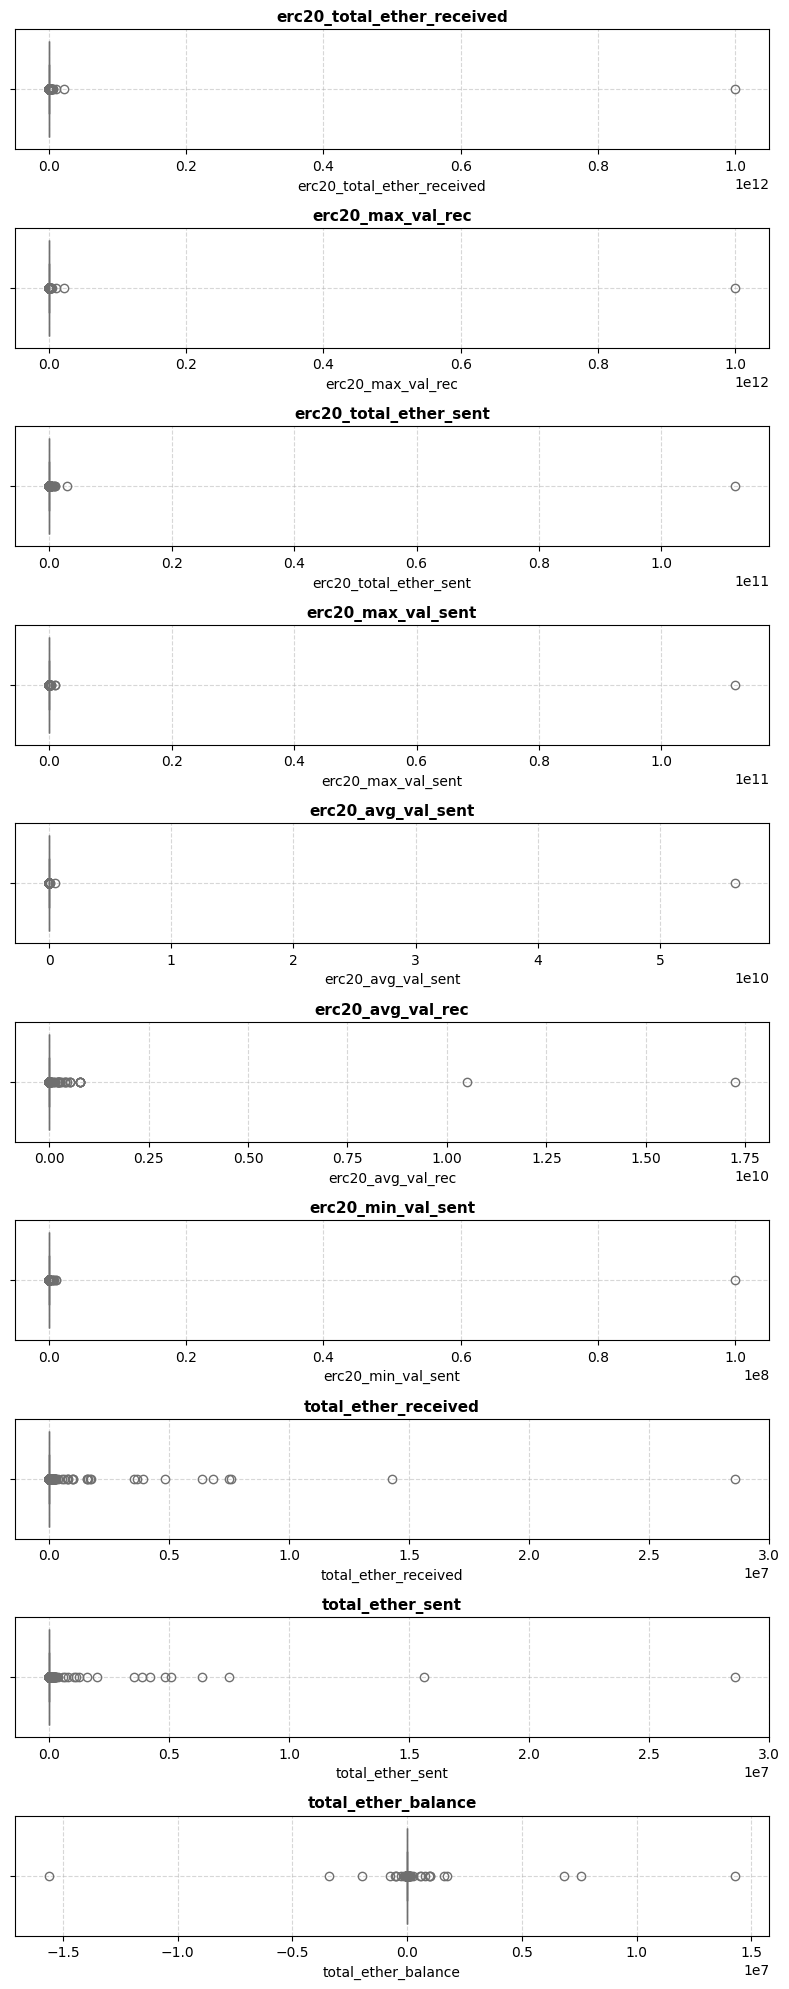

In [16]:
# Plot boxplots for top numeric columns with highest outliers to visualize extreme values
plt.figure(figsize=(8, 2*len(top_outlier_cols)))

for i, col in enumerate(top_outlier_cols, 1):
    plt.subplot(len(top_outlier_cols), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col, fontsize=11, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [17]:
# Handle negative 'total_ether_balance' values
negative_count = (df['total_ether_balance'] < 0).sum()
negative_count


np.int64(976)

In [18]:
#  Inspect their basic statistics (min, max, mean, count)
neg_values = df.loc[df['total_ether_balance'] < 0, 'total_ether_balance']
neg_stats = neg_values.agg(['min', 'max', 'mean', 'count'])
neg_stats


min     -1.560535e+07
max     -1.818811e-03
mean    -2.492396e+04
count    9.760000e+02
Name: total_ether_balance, dtype: float64

In [19]:

threshold = -100
negative_large = df[df['total_ether_balance'] < threshold]
negative_large_count = negative_large.shape[0]
negative_large_count


176

In [20]:
# Remove rows with balances less than -100
df = df.loc[df['total_ether_balance'] >= -100]

In [21]:

# Apply thresholds to filter extreme outlier values for selected columns
thresholds = {
    'erc20_total_ether_received': 1e12,
    'erc20_max_val_rec': 1e12,
    'erc20_total_ether_sent': 1.1e11,
    'erc20_max_val_sent': 1.1e11,
    'erc20_avg_val_sent': 5.6e10,
    'erc20_min_val_sent': 1e8,
}

for col, th in thresholds.items():
    df = df.loc[df[col] <= th]

top_10_after = {col: df[col].nlargest(10).values for col in top_outlier_cols}
top_10_after_df = pd.DataFrame(top_10_after)
top_10_after_df


,erc20_total_ether_received,erc20_max_val_rec,erc20_total_ether_sent,erc20_max_val_sent,erc20_avg_val_sent,erc20_avg_val_rec,erc20_min_val_sent,total_ether_received,total_ether_sent,total_ether_balance
0,2.100000e+10,2.100000e+10,2.967426e+09,1.000010e+09,5.000050e+08,1.050000e+10,1000000.0000,2.858159e+07,2.858096e+07,1.428864e+07
1,1.000111e+10,1.000000e+10,1.004207e+09,9.990000e+08,7.065300e+07,7.765160e+08,990000.0000,1.428864e+07,7.492531e+06,7.575053e+06
2,6.000021e+09,3.565778e+09,1.000010e+09,3.020247e+08,4.630089e+07,7.765159e+08,742500.0000,7.575053e+06,6.367315e+06,6.816797e+06
3,5.933215e+09,3.000000e+09,3.023315e+08,2.770000e+08,2.789465e+07,7.765159e+08,594000.0000,7.492818e+06,4.837925e+06,1.737265e+06
4,3.359245e+09,1.553054e+09,2.778053e+08,2.000000e+08,1.280218e+07,7.765158e+08,499999.9000,6.816797e+06,3.864752e+06,1.594944e+06
5,3.260809e+09,1.553054e+09,2.356366e+08,1.552959e+08,9.402372e+06,7.765155e+08,480449.0960,6.368024e+06,3.533846e+06,1.001452e+06
6,3.167027e+09,1.553054e+09,2.248063e+08,1.187500e+08,9.017415e+06,7.765146e+08,200000.0000,4.840009e+06,1.045348e+06,9.966723e+05
7,3.113901e+09,1.553054e+09,2.230996e+08,1.149972e+08,7.314438e+06,5.263743e+08,138600.0000,3.899781e+06,2.957150e+05,9.330624e+05
8,3.111159e+09,1.553054e+09,1.861699e+08,7.500000e+07,6.718478e+06,5.176772e+08,117122.7193,3.533847e+06,2.780229e+05,7.986463e+05
9,3.107089e+09,1.553054e+09,1.731536e+08,7.341721e+07,5.610394e+06,5.176771e+08,107850.8170,1.737265e+06,2.422778e+05,5.905717e+05


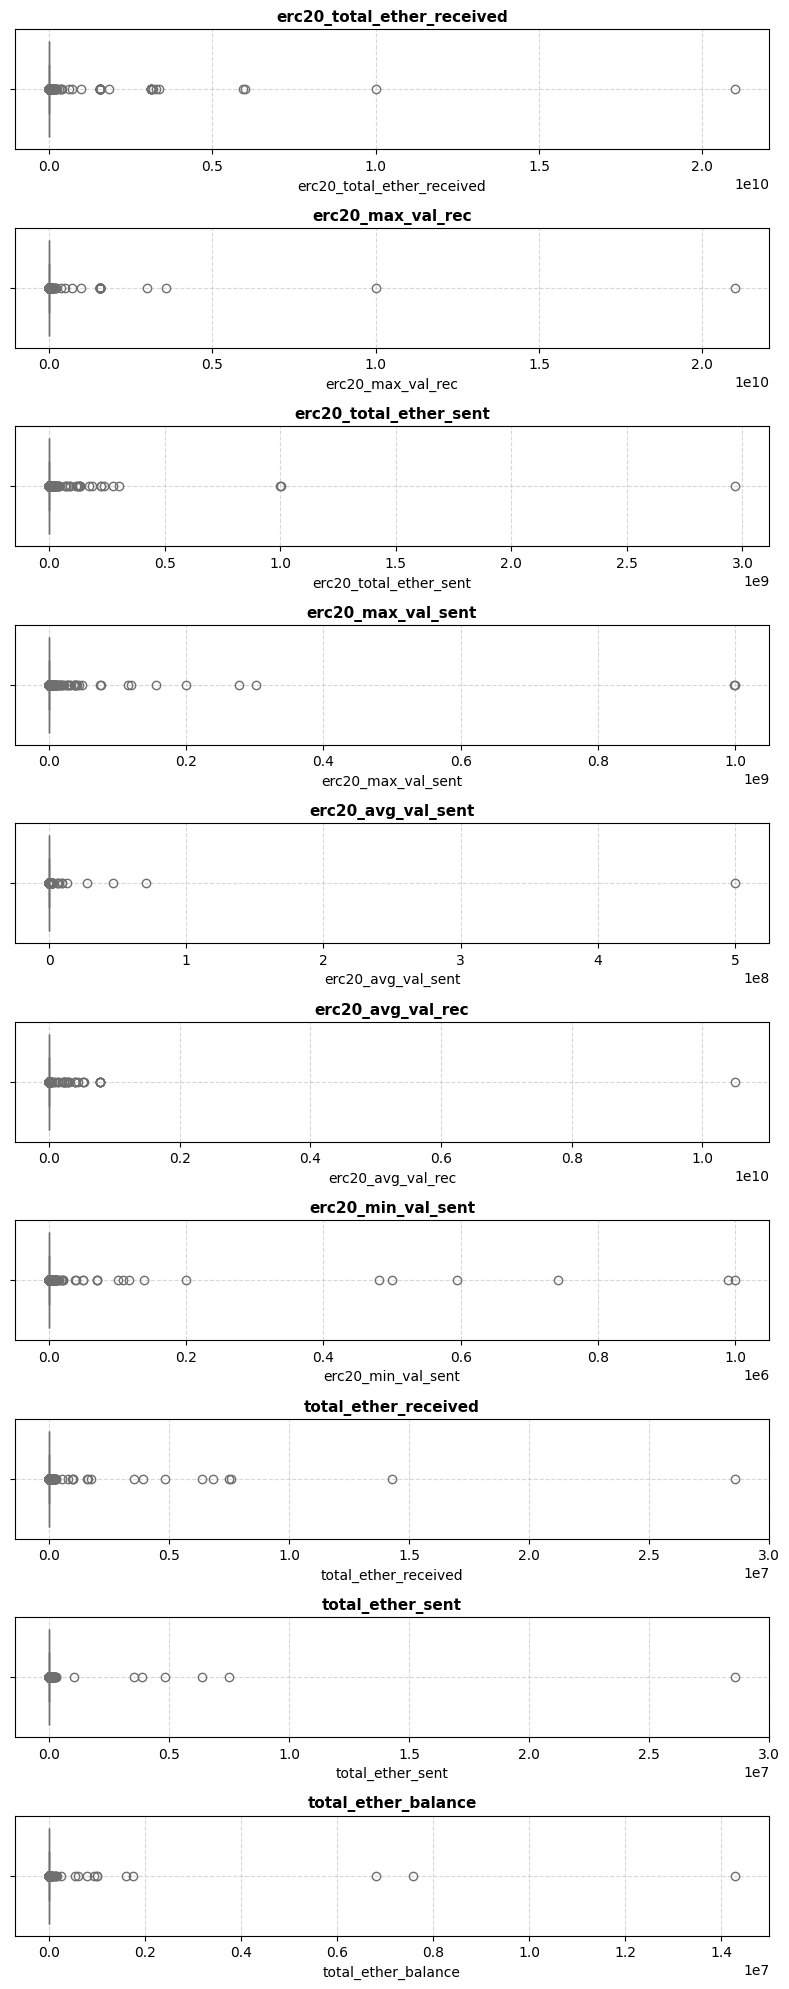

In [22]:
# Plot boxplots for top numeric columns to visualize outliers after filtering extreme values
plt.figure(figsize=(8, 2*len(top_outlier_cols)))

for i, col in enumerate(top_outlier_cols, 1):
    plt.subplot(len(top_outlier_cols), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col, fontsize=11, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Handle Messing Values**

In [23]:
df.isnull().sum().sort_values(ascending=False).head(10)


erc20_most_sent_token_type                 1839
erc20_most_rec_token_type                    41
flag                                          0
avg_min_between_sent_tnx                      0
sent_tnx                                      0
received_tnx                                  0
avg_min_between_received_tnx                  0
time_diff_between_first_and_last_(mins)       0
unique_sent_to_addresses                      0
min_value_received                            0
dtype: int64

In [24]:
# Filled missing values with mode ('no_token') as it's the most common value
df['erc20_most_sent_token_type'] = df['erc20_most_sent_token_type'].fillna(df['erc20_most_sent_token_type'].mode()[0])
df['erc20_most_rec_token_type'] = df['erc20_most_rec_token_type'].fillna(df['erc20_most_rec_token_type'].mode()[0])


In [25]:
df.isnull().sum().sort_values(ascending=False).head(10)

flag                                       0
avg_min_between_sent_tnx                   0
avg_min_between_received_tnx               0
time_diff_between_first_and_last_(mins)    0
sent_tnx                                   0
received_tnx                               0
number_of_created_contracts                0
unique_received_from_addresses             0
unique_sent_to_addresses                   0
min_value_received                         0
dtype: int64

In [26]:
# Save Cleaned Data
df.to_csv('cleaned_transaction_data.csv', index=False)



**EDA**


In [27]:
# Read cleaned data
df = pd.read_csv('cleaned_transaction_data.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8569 entries, 0 to 8568
Data columns (total 48 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   flag                                                   8569 non-null   int64  
 1   avg_min_between_sent_tnx                               8569 non-null   float64
 2   avg_min_between_received_tnx                           8569 non-null   float64
 3   time_diff_between_first_and_last_(mins)                8569 non-null   float64
 4   sent_tnx                                               8569 non-null   int64  
 5   received_tnx                                           8569 non-null   int64  
 6   number_of_created_contracts                            8569 non-null   int64  
 7   unique_received_from_addresses                         8569 non-null   int64  
 8   unique_sent_to_addresses                        

In [29]:
# Show correlation of all numeric features with 'flag'
df.select_dtypes(include=['int64', 'float64']).corr()['flag'].sort_values(ascending=False).head(15)

flag                               1.000000
erc20_uniq_sent_token_name         0.033925
erc20_avg_val_rec                  0.025551
erc20_min_val_sent                 0.018130
erc20_total_ether_sent_contract    0.016001
erc20_min_val_rec                  0.015211
min_val_sent                       0.015191
avg_min_between_sent_tnx           0.013157
erc20_max_val_rec                  0.010752
min_value_received                 0.007908
erc20_total_ether_received         0.006684
erc20_uniq_rec_token_name          0.004912
erc20_uniq_rec_contract_addr       0.004197
erc20_uniq_sent_addr.1             0.000144
erc20_max_val_sent                 0.000073
Name: flag, dtype: float64

In [30]:
df['flag'].value_counts()

flag
0    7471
1    1098
Name: count, dtype: int64

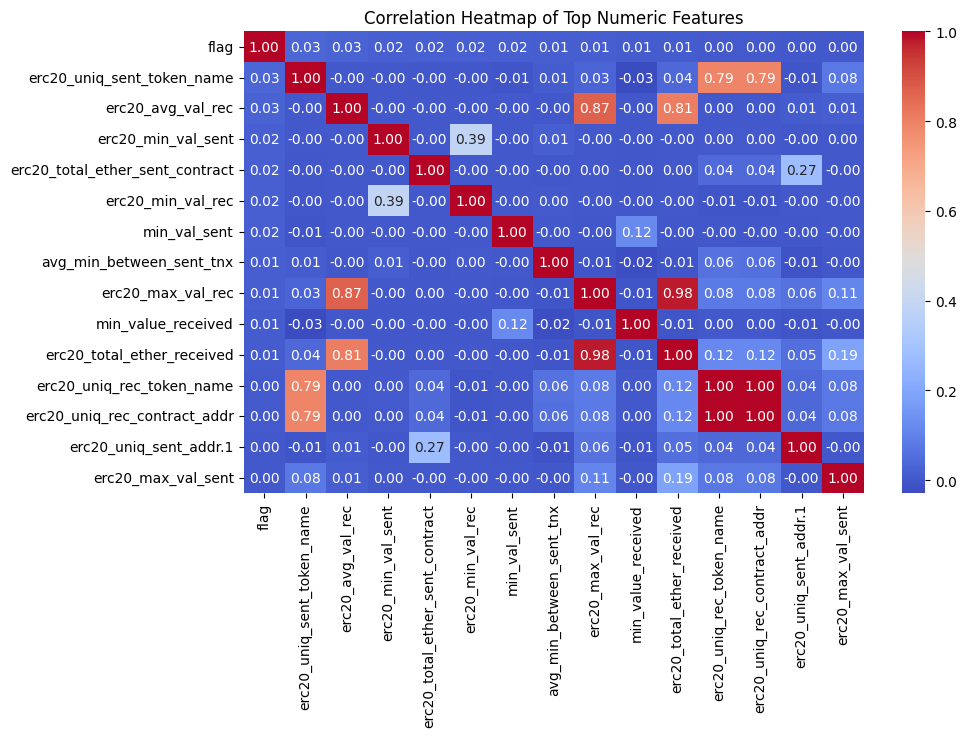

In [31]:
# Visualize correlation heatmap for top correlated features

df.select_dtypes(include=['int64', 'float64']).corr()['flag'].sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.heatmap(
    df[df.select_dtypes(include=['int64', 'float64']).corr()['flag']
       .sort_values(ascending=False).head(15).index].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Correlation Heatmap of Top Numeric Features")
plt.show()

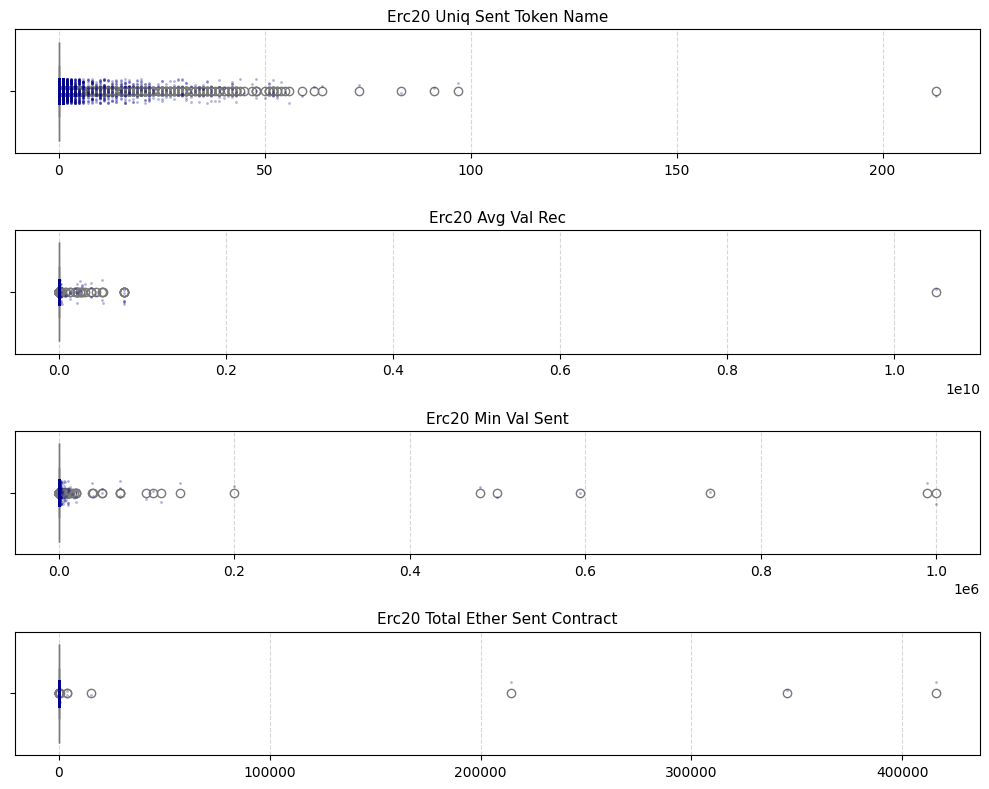

In [32]:
# Numeric features with highest correlation
features = [
    'erc20_uniq_sent_token_name',
    'erc20_avg_val_rec',
    'erc20_min_val_sent',
    'erc20_total_ether_sent_contract'
]

plt.figure(figsize=(10, 8))

for i, col in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.boxplot(x=df[col], color='lightblue')
    sns.stripplot(x=df[col], color='darkblue', alpha=0.3, size=2)
    plt.title(col.replace('_', ' ').title(), fontsize=11)
    plt.xlabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [33]:
# Chi-Square Test for categorical features and target


for col in ['erc20_most_sent_token_type', 'erc20_most_rec_token_type']:
    contingency = pd.crosstab(df[col], df['flag'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"{col} -> p-value: {p:.5f}")


erc20_most_sent_token_type -> p-value: 0.01067
erc20_most_rec_token_type -> p-value: 0.00000


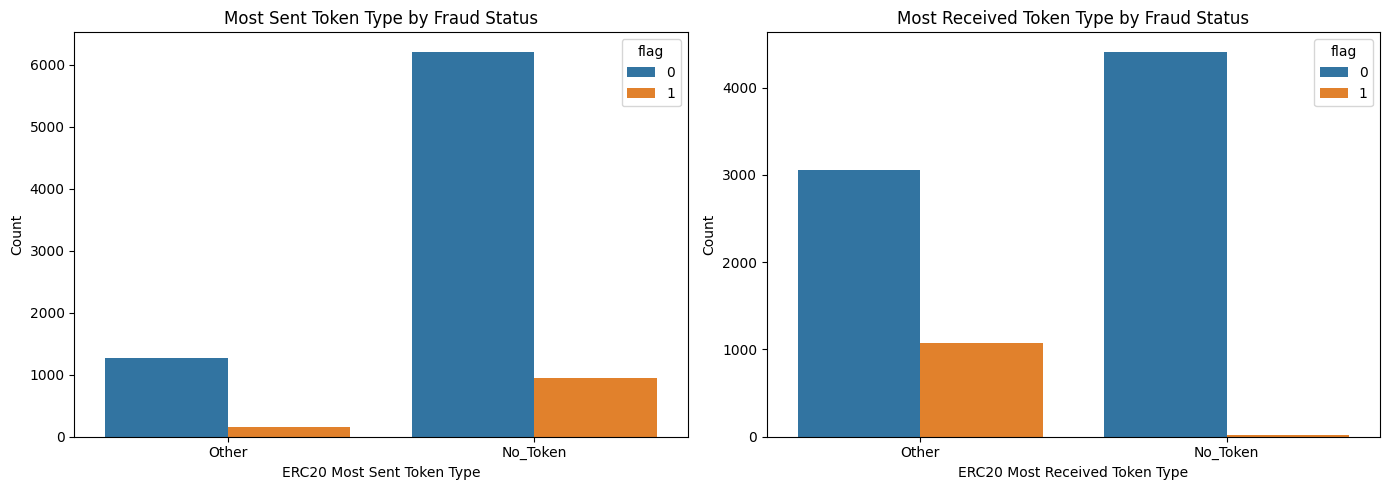

In [34]:
# Visualize categorical feature distributions by fraud status

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='erc20_most_sent_token_type', hue='flag', data=df, ax=axes[0])
axes[0].set_title('Most Sent Token Type by Fraud Status')
axes[0].set_xlabel('ERC20 Most Sent Token Type')
axes[0].set_ylabel('Count')

sns.countplot(x='erc20_most_rec_token_type', hue='flag', data=df, ax=axes[1])
axes[1].set_title('Most Received Token Type by Fraud Status')
axes[1].set_xlabel('ERC20 Most Received Token Type')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

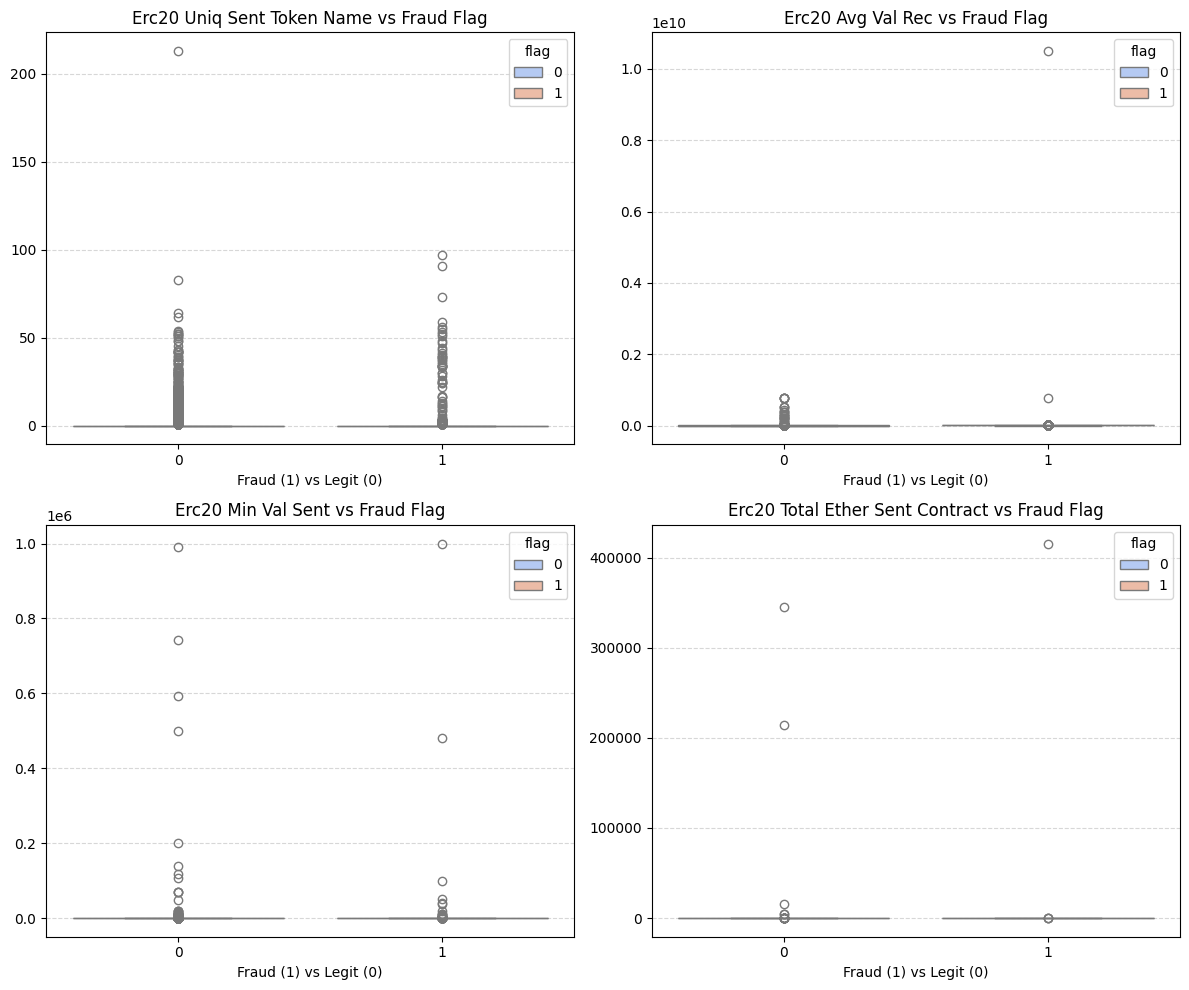

In [35]:
# Plot boxplots for selected features vs fraud flag to visualize differences between fraudulent and legitimate transactions
plt.figure(figsize=(12, 10))

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='flag', y=col, data=df, palette='coolwarm',hue='flag')
    plt.title(f"{col.replace('_', ' ').title()} vs Fraud Flag")
    plt.xlabel('Fraud (1) vs Legit (0)')
    plt.ylabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

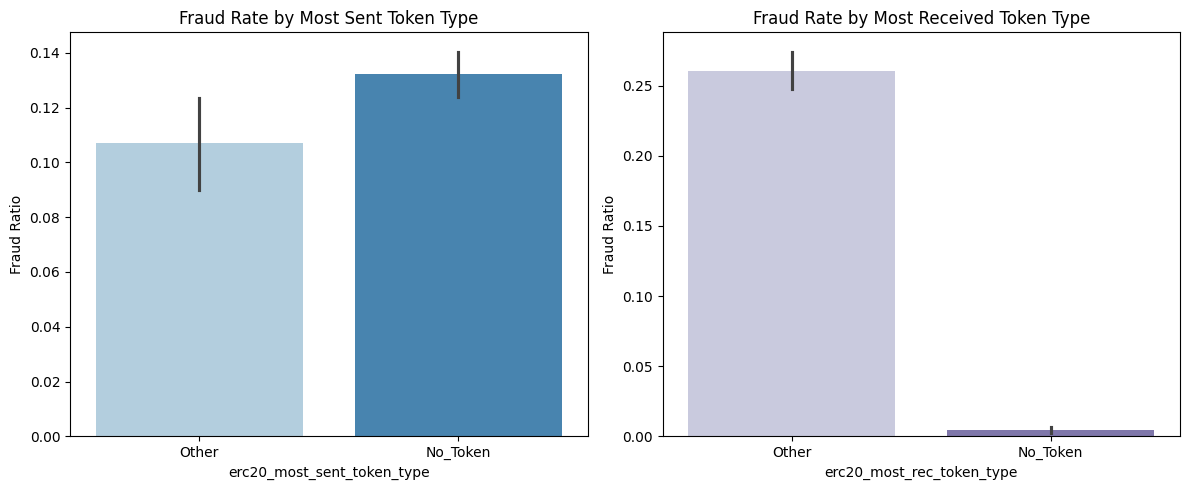

In [36]:
# Plot barplots showing the fraud rate for the most sent and most received token types
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    x='erc20_most_sent_token_type',
    y='flag',
    data=df,
    estimator=lambda x: sum(x) / len(x),  
    ax=axes[0],
    palette='Blues',
    hue='erc20_most_sent_token_type',
    legend=False
)
axes[0].set_title('Fraud Rate by Most Sent Token Type')
axes[0].set_ylabel('Fraud Ratio')

sns.barplot(
    x='erc20_most_rec_token_type',
    y='flag',
    data=df,
    estimator=lambda x: sum(x) / len(x),
    ax=axes[1],
    palette='Purples',
    hue='erc20_most_rec_token_type',
    legend=False
)
axes[1].set_title('Fraud Rate by Most Received Token Type')
axes[1].set_ylabel('Fraud Ratio')

plt.tight_layout()
plt.show()


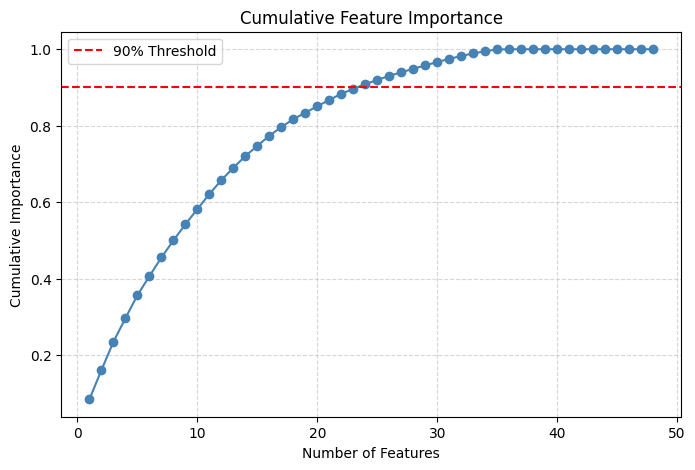

In [37]:


# Create new important feature
df['received_to_sent_ratio'] = (df['received_tnx'] + 1) / (df['sent_tnx'] + 1)

# Encode categorical features
categorical_cols = ['erc20_most_sent_token_type', 'erc20_most_rec_token_type']
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Prepare data for modeling
X = df.select_dtypes(include=['float64', 'int64']).drop('flag', axis=1)
y = df['flag']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train RandomForest 
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# Compute Feature Importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance_df['Cumulative'] = feature_importance_df['Importance'].cumsum()

#  Feature importance
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(feature_importance_df) + 1),
    feature_importance_df['Cumulative'],
    marker='o', color='steelblue'
)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
plt.title("Cumulative Feature Importance")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

    

In [38]:
# Select top features for model building
n_features_90 = np.argmax(feature_importance_df['Cumulative'] >= 0.90) + 1

selected_features = feature_importance_df['Feature'].head(n_features_90)
selected_features

0                                      total_erc20_tnxs
1                                     erc20_max_val_rec
2               time_diff_between_first_and_last_(mins)
3                            erc20_total_ether_received
4                                   erc20_uniq_rec_addr
5                          avg_min_between_received_tnx
6                             erc20_most_rec_token_type
7                                     erc20_min_val_rec
8                             erc20_uniq_rec_token_name
9                                     erc20_avg_val_rec
10                         erc20_uniq_rec_contract_addr
11                       unique_received_from_addresses
12                                 total_ether_received
13    total_transactions_(including_tnx_to_create_co...
14                                         received_tnx
15                                  total_ether_balance
16                               received_to_sent_ratio
17                                     avg_val_r

In [39]:

# Split data into Train / Validation / Test
X = df[selected_features]
y = df['flag']

# Train (80%) + Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train 60% 20% 20%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)





In [40]:

# Define baseline models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(
        random_state=42,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='aucpr'
    )
}


# Train and compare models on Validation

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_pred_val)

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": auc
    })

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df


,Model,Precision,Recall,F1,ROC-AUC
2,XGBoost,0.920000,0.940909,0.930337,0.964430
1,Random Forest,0.954545,0.859091,0.904306,0.926533
0,Decision Tree,0.830357,0.845455,0.837838,0.910010


In [41]:

# Define grid parameters
param_grid = {
    'n_estimators': [150, 200, 250],     
    'max_depth': [3, 4],              
    'learning_rate': [0.03, 0.05],       
    'subsample': [0.7, 0.8],             
    'colsample_bytree': [0.7, 0.8],      
    'reg_alpha': [1, 2],                 
    'reg_lambda': [3, 4]                 
}

# Base model
xgb_base = XGBClassifier(
    random_state=42,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()* 0.2,
    eval_metric='aucpr'
    
)

# GridSearch setup
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',    
    n_jobs=-1,
    verbose=1
)
# Fit GridSearch on the training data
grid_search.fit(X_train, y_train)

# Extract best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_



Fitting 3 folds for each of 192 candidates, totalling 576 fits


In [42]:
# Evaluate the tuned XGBoost model on the validation set


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on validation data using the tuned model
y_val_pred = best_model.predict(X_val)

print("=== Validation Performance (Tuned XGBoost) ===")
print(classification_report(y_val, y_val_pred, digits=3))





=== Validation Performance (Tuned XGBoost) ===
              precision    recall  f1-score   support

           0      0.987     0.992     0.990      1494
           1      0.944     0.914     0.928       220

    accuracy                          0.982      1714
   macro avg      0.966     0.953     0.959      1714
weighted avg      0.982     0.982     0.982      1714



In [43]:

# Retrain tuned model on (Train + Validation), then evaluate on Test


# Combine Train + Validation data
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])

# Retrain the model using best parameters
final_model = XGBClassifier(**best_params, random_state=42,
                            scale_pos_weight=(y_train_final == 0).sum() / (y_train_final == 1).sum()* 0.2,
                            eval_metric='aucpr',       
                            min_child_weight=4,   

                            )
final_model.fit(X_train_final, y_train_final)


y_train_final_pred = final_model.predict(X_train_final) 
y_test_pred = final_model.predict(X_test)


print("=== Final Test Performance (Unseen Data) ===")
print(classification_report(y_test, y_test_pred, digits=3))


y_val_proba = final_model.predict_proba(X_val)[:,1]





=== Final Test Performance (Unseen Data) ===
              precision    recall  f1-score   support

           0      0.989     0.993     0.991      1494
           1      0.949     0.923     0.935       220

    accuracy                          0.984      1714
   macro avg      0.969     0.958     0.963      1714
weighted avg      0.984     0.984     0.984      1714



In [44]:
# Save model
xgb_package = {
    "model": final_model,               
    "encoder": le,                      
    "features": selected_features.tolist(),  
    "train_min": X_train_final.min(),   
    "train_max": X_train_final.max()  
}


joblib.dump(xgb_package, "xgb_model_package.pkl")

['xgb_model_package.pkl']